In [188]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

In [60]:
xtrain=xgb.DMatrix('./12.XGBoost/agaricus_train.txt')
ytrain=xtrain.get_label()
xtest=xgb.DMatrix('./12.XGBoost/agaricus_test.txt')
ytest=xtest.get_label()
print()
print('there are #%d in train set,%d are positive'%(xtrain.num_row(),np.sum(ytrain)))
print('there are #%d in test set,%d are positive'%(xtest.num_row(),np.sum(ytest)))
print('there are %d cols'%(xtrain.num_col()))
watch_list=[(xtrain,'trainSET'),(xtest,'testSET')]

[08:33:10] 6513x126 matrix with 143286 entries loaded from ./12.XGBoost/agaricus_train.txt
[08:33:10] 1611x126 matrix with 35442 entries loaded from ./12.XGBoost/agaricus_test.txt

there are #6513 in train set,3140 are positive
there are #1611 in test set,776 are positive
there are 126 cols


In [162]:
def auc_eval(yhat,y):
    yhat=yhat>=0.5
    y=y.get_label()==1
    tp=np.sum(y*yhat)
    fp=np.sum((~y)*yhat)
    tn=np.sum((~y)*(~yhat))
    fn=np.sum(y*(~yhat))
    tpr=(tp)/(tp+fn)
    fpr=(fp)/(tn+fp)
    return 'tpr',tpr
def custom_obj(yhat,y):
    '''
    I set param objective to binary:logitraw,so yhat =logitraw
    
    Loss=(y,yhat)=-sum( y*log(sigmoid(yhat))+(1-y)*log(1-sigmoid(yhat)) )
    
    let sigmoid(yhat)=p
    dloss/dp=(1-y)/(1-p) -y/p
    dloss/dyhat=dloss/dp *p*(1-p)=p-y
    
    d2_loss/d_yhat2=p(1-p)
    '''

    y=y.get_label()
    p=1/(1+np.exp(-yhat))
    g=p-y
    h=p*(1-p)
    return g,h
#https://xgboost.readthedocs.io/en/latest/parameter.html
params={'max_depth':2,
        'eta':1,
        'silent':1,
        'objective':'binary:logitraw',
        'disable_default_eval_metric':1,
#         'eval_metric':['error@0.5','logloss']
        'eval_metric':['error@0.5']
       }
num_round=5
eval_result={}
# feval return a pair,(metric name,metric value)
bst=xgb.train(params,xtrain,num_round,
              evals=watch_list,
              evals_result=eval_result
#              ,feval=auc_eval
             ,obj=custom_obj)
# [0]	trainSET-error:0.482113	testSET-error:0.481688	trainSET-tpr:1	testSET-tpr:1
# [1]	trainSET-error:0.482113	testSET-error:0.481688	trainSET-tpr:1	testSET-tpr:1
# [2]	trainSET-error:0.482113	testSET-error:0.481688	trainSET-tpr:1	testSET-tpr:1

[0]	trainSET-error:0.046522	testSET-error:0.042831
[1]	trainSET-error:0.022263	testSET-error:0.021726
[2]	trainSET-error:0.0152	testSET-error:0.018001
[3]	trainSET-error:0.0152	testSET-error:0.018001
[4]	trainSET-error:0.007063	testSET-error:0.006207


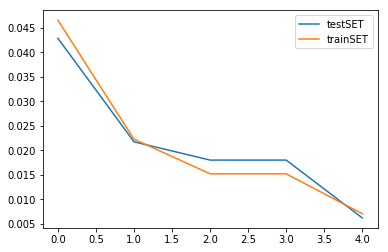

In [163]:
plt.figure()
for key,measure in eval_result.items():
    plt.plot(measure['error'],label=key)
plt.legend()

# example 2 iris

In [269]:
data=pd.read_csv('./8.Regression/iris.data',header=None)
data[4]=pd.Categorical(data[4]).codes
X,Y=data[[0,1,2,3]],data[4]
trainX,testX,trainY,testY=train_test_split(X,Y,train_size=0.8,random_state=0)
# Xtrain,Xtest,Ytrain,Ytest=train_test_split(Xdata)
trainSet=xgb.DMatrix(trainX,trainY)
testSet=xgb.DMatrix(testX,testY)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [273]:
params={'max_depth':3,'eta':1,'silent':1,'objective':'multi:softmax','num_class':3}
num_round=8
bst=xgb.train(params,trainSet,num_round,evals=[(trainSet,'trainset'),(testSet,'testset')])

[0]	trainset-merror:0.033333	testset-merror:0
[1]	trainset-merror:0.041667	testset-merror:0.033333
[2]	trainset-merror:0.008333	testset-merror:0
[3]	trainset-merror:0	testset-merror:0
[4]	trainset-merror:0	testset-merror:0
[5]	trainset-merror:0	testset-merror:0
[6]	trainset-merror:0	testset-merror:0
[7]	trainset-merror:0	testset-merror:0


In [268]:
ypred=bst.predict(testSet)
print((ypred!=testSet.get_label()).mean())

0.0


In [263]:
ypred

array([2., 1., 0., 2., 0., 2., 0., 1., 1., 1., 2., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 2., 1., 0., 0., 2., 0., 0., 1., 1., 0.], dtype=float32)

In [247]:
testSet.get_label()

array([2., 1., 0., 2., 0., 2., 0., 1., 1., 1., 2., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 2., 1., 0., 0., 2., 0., 0., 1., 1., 0.], dtype=float32)